In [9]:
import numpy as np
from scipy.integrate import quad

class Heston:
    def __init__(self, S0, v0, r, k, theta, eta, rho):
        self.S0 = S0
        self.v0 = v0
        self.r = r
        self.k = k
        self.theta = theta
        self.eta = eta
        self.rho = rho
        self.gamma = eta**2/2.0
    def P(self, j, x, tau):
        return 0.5+1.0/np.pi*(quad(self.integrand, 0.0, np.inf, args = (j, x, self.v0, tau)))[0]
    def integrand(self, u, j, x, v, tau):
        return np.real(np.exp(self.C(j, u, tau)*self.theta+self.D(j, u, tau)*v+1j*u*x)/(u*1j))
    def C(self, j, u, tau):
        g = self.rminus(j, u)/self.rplus(j, u)
        return self.k*(self.rminus(j,u)*tau-2.0/self.eta**2*np.log((1.0-g*np.exp(-self.d(j,u)*tau))/(1.0-g)))
    def d(self, j, u):
        return np.sqrt(self.beta(j,u)**2-4*self.alpha(j,u)*self.gamma)
    def rminus(self, j, u):
        return (self.beta(j, u)-self.d(j,u))/(2*self.gamma)
    def rplus(self, j, u):
        return (self.beta(j, u) + self.d(j, u))/(2*self.gamma)
    def beta(self, j, u):
        return self.k - self.rho*self.eta*j - self.rho*self.eta*u*1j
    def alpha(self, j, u):
        return -u**2/2-u*1j/2+j*u*1j
    def D(self, j, u, tau):
        g = self.rminus(j, u)/self.rplus(j, u)
        return self.rminus(j,u)*(1.0-np.exp(-self.d(j,u)*tau))/(1.0-g*np.exp(-self.d(j,u)*tau))
    def callprice(self, strike, tau):
        B = np.exp(-self.r*tau)
        F = self.S0/B
        x = np.log(F/strike)
        return B*(F*self.P(1,x,tau)-strike*self.P(0,x,tau))
#     def putprice(self, strike, tau):
#         B = np.exp(-self.r*tau)
#         F = self.S0/B
#         x = np.log(F/strike)
#         return B*(strike*self.P(0,-x,tau)-F*self.P(1,-x,tau))
    def putprice_test(self, strike, tau):
        B = np.exp(-self.r*tau)
        F = self.S0/B
        x = np.log(F/strike)
        return self.callprice(strike, tau) - self.S0 + B*strike #put price defined by put-call parity

#defining function HestonOption that calls the above class as req'd

def HestonOption(S0, v0, strike, eta, r, tau, callput, k, theta, rho):
    hestonmodel = Heston(S0, v0, r, k, theta, eta, rho)
    if callput == 1:
        return hestonmodel.callprice(strike, tau)
    elif callput == -1:
        return hestonmodel.putprice_test(strike, tau)
    else:
        raise ValueError("callput must be either 1 (call) or -1 (put)")
        
stock = float(input('Enter the underlying stock price: '))
strike = float(input('Enter the strike price: '))
v0 = float(input('Enter the initial volatility: '))
interest = float(input('Enter continuously compounded interest rate: '))
maturity = float(input('Enter the time to maturity: '))
callput = int(input('Enter 1 for call or -1 for put option: '))
eta = float(input('Enter the volatility of volatility: '))
k = float(input('Enter the speed of mean reversion: '))
theta = float(input('Enter the long-run mean volatility: '))
rho = float(input('Enter the instantaneous correlation: '))
result = HestonOption(stock,v0,strike,eta,interest,maturity,callput,k,theta,rho)
print('The option price is '+str(result))

Enter the underlying stock price: 100
Enter the strike price: 102
Enter the initial volatility: 0.03
Enter continuously compounded interest rate: 0.05
Enter the time to maturity: 1.5
Enter 1 for call or -1 for put option: 1
Enter the volatility of volatility: 0.3
Enter the speed of mean reversion: 0.9
Enter the long-run mean volatility: 0.07
Enter the instantaneous correlation: -0.6
The option price is 12.98918523168881


# Fitting a Heston model to option price data
The data in the file `TSLA.xlsx`, contains data on options on Tesla, Inc. (TSLA) traded on CBOE on 8 March 2023. The price of TSLA on that day was USD 182.00. The options are American style, but TSLA isn't paying any dividends, so call options can be priced as if they were European.
We will be calculating the bid and ask Black/Scholes implied volatilities of all call options expiring on 15 March 2024, which had a nonzero trading volume on CBOE on 8 March 2023. We will assume that the riskfree rate for this maturity was 5.751038% continuously compounded, using an ACT/365 daycount convention (i.e., the time to maturity in years is given by the number of days between 8 March 2023 and 15 March 2024, divided by 365). 

The heston model parameters will be calibrated based on the the implied volatility curves of the above. 

#### Setup blackscholes and implied volatility function

In [3]:
from scipy import optimize
from scipy.stats import norm

#defining blackscholes pricing function
def blackscholes(S, K, sigma, r, T, callput):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - (sigma * np.sqrt(T))
    if callput == 1:
        option_price = S * norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * norm.cdf(d2, 0, 1)
    elif callput == -1:
        option_price = K * np.exp(-r * T) * norm.cdf(-d2, 0, 1) - S * norm.cdf(-d1, 0, 1)
    else:
        raise ValueError("callput must be either 1 (call) or -1 (put)")
    return option_price    

#defining prior function that will be used by root_scalar 
def prior_func(sigma, S, K, r, T, callput, price):
     return blackscholes(S, K, sigma, r, T, callput) - price 

#defining the implied volatility function
def BlackScholesImpVol(S, K, r, T, callput, price):
    # Find the implied volatility by solving the objective function using the root_scalar method
    implied_vol = optimize.root_scalar(prior_func, bracket=[0.001, 10], args=(S, K, r,
                                                                              T, callput, price))
    return implied_vol.root

#print('The implied volatility is: ' + str(BlackScholesImpVol(100,100,0.05,2,1,22.7251160722058)))

#### Plotting Bid and Ask Black Scholes Implied Volatility Curves

/var/folders/mp/_m7_15bd59q6ry66dn_mvmvh0000gn/T/ipykernel_43084/3202769241.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_mar15['imp_vol_ask'] = np.vectorize(BlackScholesImpVol)(tsla_price, tsla_mar15['Strike'], interest,
/var/folders/mp/_m7_15bd59q6ry66dn_mvmvh0000gn/T/ipykernel_43084/3202769241.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsla_mar15['imp_vol_bid'] = np.vectorize(BlackScholesImpVol)(tsla_price, tsla_mar15['Strike'], interest,


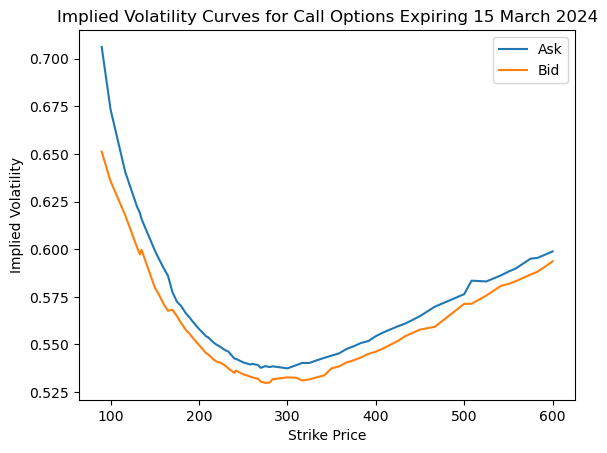

In [4]:
import pandas as pd
from datetime import datetime

#reading in tsla.xlsx data
tsla = pd.read_excel("TSLA.xlsx")

#getting rid of columns related to puts
tsla.drop(columns = tsla.columns[-7:], axis = 1, inplace = True) 

#formatting the date column and filtering for calls expiring on 15th March 2024 and Volume > 0
tsla['expiry_date_formatted'] = pd.to_datetime(tsla['Expiration Date'], format = "%a %b %d %Y")
tsla_mar15 = tsla[(tsla['expiry_date_formatted'] == '2024-03-15') & (tsla['Volume'] > 0)]

#defining maturity days and global variables
days_to_maturity = (datetime(2024, 3, 15) - datetime(2023, 3, 8)).days
maturity = days_to_maturity / 365.0
tsla_price = 182.00
interest = 0.05751038
callput = 1

tsla_mar15['imp_vol_ask'] = np.vectorize(BlackScholesImpVol)(tsla_price, tsla_mar15['Strike'], interest, 
                                                             maturity, callput, tsla_mar15['Ask'])

tsla_mar15['imp_vol_bid'] = np.vectorize(BlackScholesImpVol)(tsla_price, tsla_mar15['Strike'], interest, 
                                                            maturity, callput, tsla_mar15['Bid'])

# print(tsla_mar15)

# Plot implied volatility curves for bid and ask prices
import matplotlib.pyplot as plt

plt.plot(tsla_mar15['Strike'], tsla_mar15['imp_vol_ask'], label='Ask')
plt.plot(tsla_mar15['Strike'], tsla_mar15['imp_vol_bid'], label='Bid')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Curves for Call Options Expiring 15 March 2024')
plt.legend()
plt.show()

## Optimising Heston Model Parameters
### Below is code that will create a seperate set of parameters for heston model for each option within the TSLA dataset

In [10]:
from scipy.optimize import minimize
from scipy import optimize

#define variables to be used in optimisation
S0 = tsla_price
r = interest
strike = tsla_mar15['Strike'].to_numpy('float')
tau = maturity
iv_bid = tsla_mar15['imp_vol_bid'].to_numpy('float')
iv_ask = tsla_mar15['imp_vol_ask'].to_numpy('float')


params = {"v0": {"x0": 0.03, "lbub": [1e-3, 1]},
         "k": {"x0": 0.9, "lbub" :[1e-3, 5]},
         "theta": {"x0": 0.05, "lbub": [1e-3, 5]},
         "rho": {"x0": -0.6, "lbub": [-1, 1]},
         "eta": {"x0": 0.3, "lbub": [0, 1]}
         }

x0 = [param["x0"] for key, param in params.items()]
bnds = [param["lbub"] for key, param in params.items()]


# Define the objfct function to be minimised for each iteration of strike, iv_bid, and iv_ask
def objfct(x, strike_price, bid, ask):
    v0, k, theta, rho, eta = [param for param in x]
    
    hestonprice = HestonOption(S0, v0, strike_price, eta, r, tau, callput, k, theta, rho)
    heston_impvol = BlackScholesImpVol(S0, strike_price, r, maturity, callput, hestonprice)

    if heston_impvol < bid:
        error = (bid - heston_impvol)**2
    elif heston_impvol > ask:
        error = (ask - heston_impvol)**2
    else:
        error = 0

    return error

#creating new dataframe to host optimized values of heston parameters
tsla_opt = tsla_mar15.reset_index(drop = True)

# print(tsla_opt)
# Create new columns in the tsla_opt dataframe to store the optimized parameter values
tsla_opt['v0'] = np.nan
tsla_opt['k'] = np.nan
tsla_opt['theta'] = np.nan
tsla_opt['rho'] = np.nan
tsla_opt['eta'] = np.nan

# print(tsla_opt)

# Loop over the length of iv_bid and optimize the parameters for each set of strike, iv_bid, and iv_ask values
for i in range(len(iv_bid)):
    strike_price = strike[i]
    bid = iv_bid[i]
    ask = iv_ask[i]
    
    # Optimize the parameters using SLSQP
    result = minimize(objfct, x0, args=(strike_price, bid, ask), method="SLSQP", bounds=bnds, tol=1e-6, options={'maxiter': 1e4})
    
    # Store the optimized parameter values in the corresponding columns of the tsla_opt dataframe
    tsla_opt.loc[i, 'v0'] = result.x[0]
    tsla_opt.loc[i, 'k'] = result.x[1]
    tsla_opt.loc[i, 'theta'] = result.x[2]
    tsla_opt.loc[i, 'rho'] = result.x[3]
    tsla_opt.loc[i, 'eta'] = result.x[4]
    
#Heston prices using optimised heston parameters
tsla_opt['heston_price'] = np.vectorize(HestonOption)(tsla_price, tsla_opt['v0'], tsla_opt['Strike'],
                                                        tsla_opt['eta'], r, tau, callput, tsla_opt['k'], 
                                                        tsla_opt['theta'], tsla_opt['rho'])

# print(tsla_opt)

#BS Imp Vol using optimised heston parameters
tsla_opt['heston_imp_vol'] = np.vectorize(BlackScholesImpVol)(tsla_price, tsla_opt['Strike'], interest, 
                                                            maturity, callput, tsla_opt['heston_price'])

print(tsla_opt)

    Expiration Date                Calls  Last Sale    Net     Bid     Ask  \
0   Fri Mar 15 2024  TSLA240315C00090000     101.58 -8.170  101.95  103.35   
1   Fri Mar 15 2024  TSLA240315C00100000      94.15 -7.675   94.20   95.35   
2   Fri Mar 15 2024  TSLA240315C00116670      82.64 -6.785   82.20   83.10   
3   Fri Mar 15 2024  TSLA240315C00130000      73.39 -6.785   73.15   74.15   
4   Fri Mar 15 2024  TSLA240315C00133330      71.13 -6.820   71.00   72.05   
..              ...                  ...        ...    ...     ...     ...   
57  Fri Mar 15 2024  TSLA240315C00550000       2.80 -0.525    2.62    2.78   
58  Fri Mar 15 2024  TSLA240315C00558330       2.61 -0.590    2.51    2.67   
59  Fri Mar 15 2024  TSLA240315C00575000       2.39 -0.590    2.32    2.51   
60  Fri Mar 15 2024  TSLA240315C00583330       2.40 -0.470    2.23    2.39   
61  Fri Mar 15 2024  TSLA240315C00600000       2.17 -0.505    2.11    2.22   

    Volume  Open Interest  Strike expiry_date_formatted  imp_vo

## Plotting Implied Volatility of Each Curve

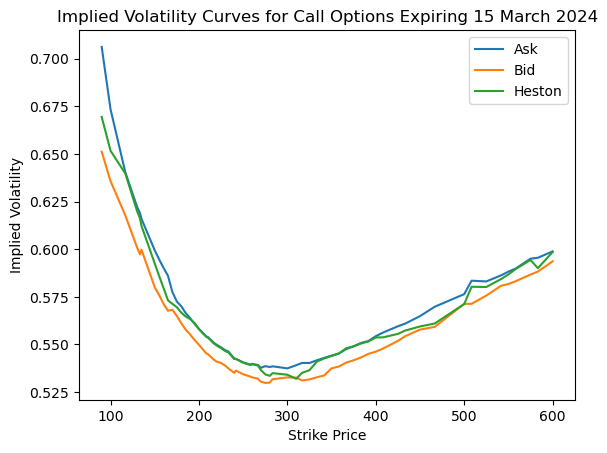

In [11]:
# Plot implied volatility curves for heston, bid and ask prices
import matplotlib.pyplot as plt

plt.plot(tsla_opt['Strike'], tsla_opt['imp_vol_ask'], label='Ask')
plt.plot(tsla_opt['Strike'], tsla_opt['imp_vol_bid'], label='Bid')
plt.plot(tsla_opt['Strike'], tsla_opt['heston_imp_vol'], label = 'Heston')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Curves for Call Options Expiring 15 March 2024')
plt.legend()
plt.show()

## An Alternative
Below is code that optimises for single parameter values for all options, rather than having different heston model parameters for each option within the TSLA dataframe. The objective function being minimised has been altered slighly for this.


In [15]:
from scipy.optimize import minimize
from scipy import optimize

tsla_test = tsla_mar15.reset_index(drop = True)

#define variables to be used in optimisation
S0 = tsla_price
r = interest
strike = tsla_test['Strike'].to_numpy('float')
tau = maturity
iv_bid = tsla_test['imp_vol_bid'].to_numpy('float')
iv_ask = tsla_test['imp_vol_ask'].to_numpy('float')
bid_price = tsla_test['Bid'].to_numpy('float')
ask_price = tsla_test['Ask'].to_numpy('float')
tsla_test['mid'] = (tsla_test['Bid'] + tsla_test['Ask'])/2
tsla_test['imp_vol_mid'] = np.vectorize(BlackScholesImpVol)(tsla_price, tsla_test['Strike'], interest, 
                                                            maturity, callput, tsla_test['mid'])
iv_mid = tsla_test['imp_vol_mid'].to_numpy('float')

params_v2 = {"v0": {"x0": 0.03, "lbub": [1e-3, 1]},
         "k": {"x0": 0.9, "lbub" :[1e-3, 5]},
         "theta": {"x0": 0.05, "lbub": [1e-3, 5]},
         "rho": {"x0": -0.6, "lbub": [-1, 1]},
         "eta": {"x0": 0.3, "lbub": [0, 1]}
         }

x0_v2 = [param["x0"] for key, param in params_v2.items()]
bnds_v2 = [param["lbub"] for key, param in params_v2.items()]

#defining objective function to be minimised
def objfct2(x):
    v0, k, theta, rho, eta = [param for param in x]
    total_error = []
    for i in range(len(strike)):
        strike_price = strike[i]


        heston_price = HestonOption(S0, v0, strike_price, eta, r, tau, callput, k, theta, rho)
        heston_impvol = BlackScholesImpVol(S0, strike_price, r, maturity, callput, heston_price)
        

        if heston_impvol < iv_bid[i]:
            error = (iv_bid[i] - heston_impvol)**2
        elif heston_impvol > iv_ask[i]:
            error = (iv_ask[i] - heston_impvol)**2
        else:
            error = 0

        total_error.append(error)

    return sum(total_error)

resultv2 = minimize(objfct2, x0 = x0_v2, bounds = bnds_v2, tol = 1e-6)

v0, k, theta, rho, eta = [param for param in resultv2.x]
print(v0, k, theta, rho, eta)

0.3914683740558651 0.14369886123706205 0.7632958151986345 -0.2957355005767818 0.9999894133260571


0.3914683740558651 0.14369886123706205 0.7632958151986345 -0.2957355005767818 0.9999894133260571
    Expiration Date                Calls  Last Sale    Net     Bid     Ask  \
0   Fri Mar 15 2024  TSLA240315C00090000     101.58 -8.170  101.95  103.35   
1   Fri Mar 15 2024  TSLA240315C00100000      94.15 -7.675   94.20   95.35   
2   Fri Mar 15 2024  TSLA240315C00116670      82.64 -6.785   82.20   83.10   
3   Fri Mar 15 2024  TSLA240315C00130000      73.39 -6.785   73.15   74.15   
4   Fri Mar 15 2024  TSLA240315C00133330      71.13 -6.820   71.00   72.05   
..              ...                  ...        ...    ...     ...     ...   
57  Fri Mar 15 2024  TSLA240315C00550000       2.80 -0.525    2.62    2.78   
58  Fri Mar 15 2024  TSLA240315C00558330       2.61 -0.590    2.51    2.67   
59  Fri Mar 15 2024  TSLA240315C00575000       2.39 -0.590    2.32    2.51   
60  Fri Mar 15 2024  TSLA240315C00583330       2.40 -0.470    2.23    2.39   
61  Fri Mar 15 2024  TSLA240315C00600000     

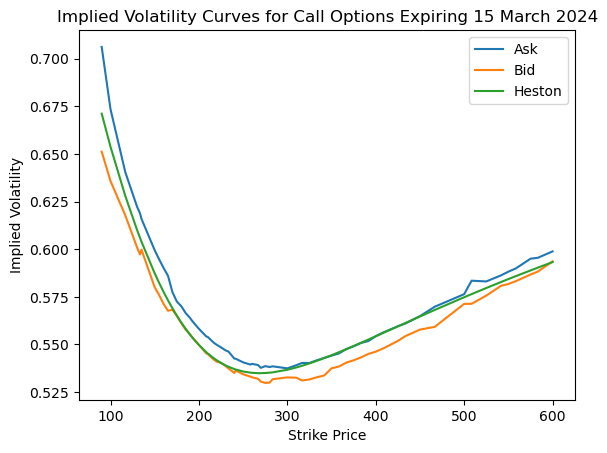

In [16]:
print(v0, k, theta, rho, eta)

#Heston prices using optimised heston parameters
tsla_test['heston_price'] = np.vectorize(HestonOption)(tsla_price, v0, tsla_test['Strike'],
                                                        eta, r, tau, callput, k, theta, rho)



#BS Imp Vol using optimised heston parameters
tsla_test['heston_imp_vol'] = np.vectorize(BlackScholesImpVol)(tsla_price, tsla_test['Strike'], interest, 
                                                            maturity, callput, tsla_test['heston_price'])
print(tsla_test)

# Plot implied volatility curves for bid and ask prices
import matplotlib.pyplot as plt

plt.plot(tsla_test['Strike'], tsla_test['imp_vol_ask'], label='Ask')
plt.plot(tsla_test['Strike'], tsla_test['imp_vol_bid'], label='Bid')
plt.plot(tsla_test['Strike'], tsla_test['heston_imp_vol'], label = 'Heston')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility Curves for Call Options Expiring 15 March 2024')
plt.legend()
plt.show()